In [1]:
#load the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re 
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings('ignore')

In [2]:
#from amazon_product_review_scraper import amazon_product_review_scraper

In [3]:
#review_scraper = amazon_product_review_scraper(amazon_site="amazon.in", product_asin="B07HG8S7KP",start_page=0,end_page=500)
#reviews_df = review_scraper.scrape()
#reviews_df.head(5) 
#I tried for 22k samples but i recieved only for 5k.
#There is a limit apparently to scrap like this. A better methodology would be to scrap 3k 
# and wait for one minute and scrap again. or automate this process to get information
#reviews_df.to_csv('reviews1.csv')

In [4]:
raw_data = pd.read_csv(r"reviews.csv").drop('Unnamed: 0',axis=1)
raw_data.head()

,date_info,name,title,content,rating
0,Reviewed in India on 9 March 2020,Ajay KS,Best Value for Money in this Range. Go for it ...,This is best thing you can get at this price f...,5.0 out of 5 stars
1,Reviewed in India on 9 March 2020,shailesh,Samsung m31 all rounder best mobile.,"Best camera, very good battery life, eat body ...",5.0 out of 5 stars
2,Reviewed in India on 9 March 2020,surojit das,Poor camera,3rd class front camera. 32 MP front camera n l...,1.0 out of 5 stars
3,Reviewed in India on 9 March 2020,Riddham Jain,"False ads, poor camera quality, inefficient ba...",Lets just begin with the obvious. This phone's...,1.0 out of 5 stars
4,Reviewed in India on 9 March 2020,Abhinav,Serious Issue,The phone was wrapped in dust. Although it was...,1.0 out of 5 stars


In [5]:
df = raw_data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5010 entries, 0 to 5009
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date_info  5010 non-null   object
 1   name       5010 non-null   object
 2   title      5010 non-null   object
 3   content    5010 non-null   object
 4   rating     5010 non-null   object
dtypes: object(5)
memory usage: 195.8+ KB


## Preprocessing data

### Cleaning data

In [6]:
#Cleaning Rating
df.rating = df.rating.apply(lambda x : x.replace(' out of 5 stars',''))
df.rating.astype('float')

0       5.0
1       5.0
2       1.0
3       1.0
4       1.0
       ... 
5005    3.0
5006    1.0
5007    5.0
5008    1.0
5009    5.0
Name: rating, Length: 5010, dtype: float64

In [7]:
#Cleaning up the Dates and making a seperate columns for country
df.date_info = df.date_info.apply(lambda x : x.replace('Reviewed in ',''))
df.date_info = df.date_info.apply(lambda x : re.sub(r"on ", "", x))

# for Country
df["country"] = df.date_info.apply(lambda x : x.split(' ',1)[0])

#splitting date
df.date_info = df.date_info.apply(lambda x : x.split(' ',1)[1])

In [8]:
# fixing the dates because they are not in the right format
from datetime import datetime
reps = {'March':'Mar','April':'Apr','May':'May','June':'Jun','July':'Jul','August':'Aug','September':'Sep',
          'October':'Oct','November':'Nov','December':'Dec','January':'Jan','February':'Feb'}
df.date_info = df.date_info.replace(reps, regex=True)
df.date_info = df.date_info.apply(lambda x : datetime.strptime(x, '%d %b %Y'))                                                                                        

In [9]:
df1 = df.copy() #we do not need content and name so we can remove it
df1=df1.drop(['name','content'],axis=1)
df1 #We can perform 

,date_info,title,rating,country
0,2020-03-09,Best Value for Money in this Range. Go for it ...,5.0,India
1,2020-03-09,Samsung m31 all rounder best mobile.,5.0,India
2,2020-03-09,Poor camera,1.0,India
3,2020-03-09,"False ads, poor camera quality, inefficient ba...",1.0,India
4,2020-03-09,Serious Issue,1.0,India
...,...,...,...,...
5005,2020-07-30,Average performance phone,3.0,India
5006,2020-09-28,NEVER RECOMMENDED. HAVING SERIOUS ISSUE WITH MIC,1.0,India
5007,2020-05-31,EXCELLENT ALL ROUND PHONE,5.0,India
5008,2020-10-13,Touch screen problem on the same day I receive...,1.0,India


### Remove StopWords

In [10]:
df1.title = df1.title.apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))
df1.head() #No need to perform stemming or lematization as titles are almost small and short

,date_info,title,rating,country
0,2020-03-09,Best Value Money Range. Go without doubt.,5.0,India
1,2020-03-09,Samsung m31 rounder best mobile.,5.0,India
2,2020-03-09,Poor camera,1.0,India
3,2020-03-09,"False ads, poor camera quality, inefficient ba...",1.0,India
4,2020-03-09,Serious Issue,1.0,India


## Product Sentiment Values

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentialz = SentimentIntensityAnalyzer()

In [12]:
sentialz.polarity_scores(df.title.iloc[2])


{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}

In [13]:
#Function to retrieve sentiment class
def get_senti_class(review): 
    analysis = sentialz.polarity_scores(review)
    # set sentiment 
    if analysis["compound"] > 0: 
        return 'positive'
    elif analysis["compound"] < 0: 
        return 'negative'
    else: 
        return 'neutral'
    
def get_sentiment(review):
    return pd.Series([sentialz.polarity_scores(review),get_senti_class(review)])

In [14]:
#Applying function to all tweets
df1[["Scores", "Sentiment"]] = df1.title.apply(get_sentiment)
df1

,date_info,title,rating,country,Scores,Sentiment
0,2020-03-09,Best Value Money Range. Go without doubt.,5.0,India,"{'neg': 0.0, 'neu': 0.315, 'pos': 0.685, 'comp...",positive
1,2020-03-09,Samsung m31 rounder best mobile.,5.0,India,"{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'comp...",positive
2,2020-03-09,Poor camera,1.0,India,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...",negative
3,2020-03-09,"False ads, poor camera quality, inefficient ba...",1.0,India,"{'neg': 0.307, 'neu': 0.693, 'pos': 0.0, 'comp...",negative
4,2020-03-09,Serious Issue,1.0,India,"{'neg': 0.565, 'neu': 0.435, 'pos': 0.0, 'comp...",negative
...,...,...,...,...,...,...
5005,2020-07-30,Average performance phone,3.0,India,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
5006,2020-09-28,NEVER RECOMMENDED. HAVING SERIOUS ISSUE WITH MIC,1.0,India,"{'neg': 0.204, 'neu': 0.64, 'pos': 0.156, 'com...",negative
5007,2020-05-31,EXCELLENT ALL ROUND PHONE,5.0,India,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...",positive
5008,2020-10-13,Touch screen problem day I received order,1.0,India,"{'neg': 0.351, 'neu': 0.649, 'pos': 0.0, 'comp...",negative


## Emotion Mining

In [15]:
df1.Sentiment.value_counts()

positive    2631
neutral     1437
negative     942
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

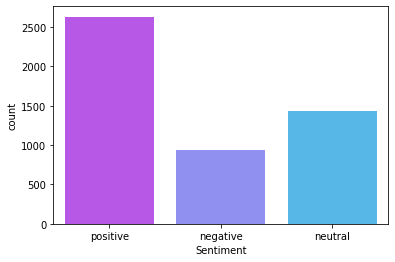

In [16]:
sns.countplot(df1.Sentiment,palette='cool_r') 

In [17]:
df1.loc[df1.Sentiment=='negative'].rating.value_counts() 
#There are some negative comments with 3,4 and 5 stars which is flawed
#Lets have a look at those values

1.0    560
2.0    133
3.0    121
5.0     66
4.0     62
Name: rating, dtype: int64

In [18]:
df1.loc[df1.Sentiment=='negative'].loc[df1.rating=='5.0']
#The algorithm clearly fails to understand certain meanings of review titles.
#Some values entered by users are wrong, but most of the errors are due to the algorithm.
#Word2Vec can be used to further analyze this.

,date_info,title,rating,country,Scores,Sentiment
194,2020-08-24,No one beat Samsung,5.0,India,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...",negative
267,2020-10-27,No prime subscription,5.0,India,"{'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'comp...",negative
276,2021-05-15,Good camera bad video camera.,5.0,India,"{'neg': 0.372, 'neu': 0.319, 'pos': 0.309, 'co...",negative
392,2020-05-27,Indeed Rounder - Avoid critical reviews lead u...,5.0,India,"{'neg': 0.467, 'neu': 0.533, 'pos': 0.0, 'comp...",negative
464,2020-11-24,Go doubt.,5.0,India,"{'neg': 0.714, 'neu': 0.286, 'pos': 0.0, 'comp...",negative
...,...,...,...,...,...,...
4426,2020-10-05,Build quilaty poor,5.0,India,"{'neg': 0.608, 'neu': 0.392, 'pos': 0.0, 'comp...",negative
4764,2020-10-19,"Ban china products,Longlasting battery securit...",5.0,India,"{'neg': 0.36, 'neu': 0.4, 'pos': 0.24, 'compou...",negative
4778,2020-10-01,Not value money product,5.0,India,"{'neg': 0.404, 'neu': 0.596, 'pos': 0.0, 'comp...",negative
4786,2020-12-21,BEST BUDGET KILLING SMARTPHONE,5.0,India,"{'neg': 0.415, 'neu': 0.189, 'pos': 0.396, 'co...",negative


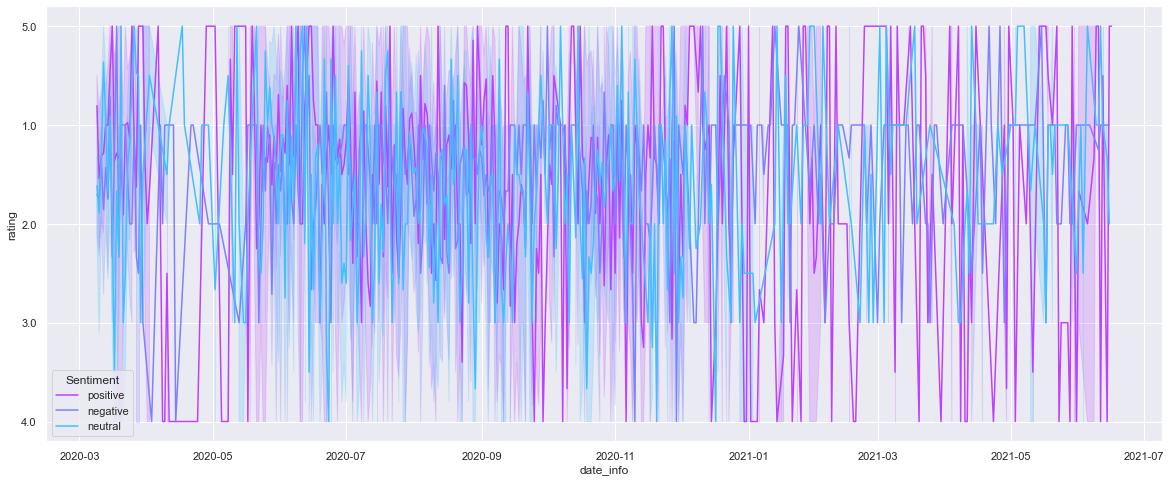

In [19]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot(x=df1.date_info,y=df1.rating,data=df1,hue=df1.Sentiment,palette='cool_r')
plt.show()

<AxesSubplot:xlabel='date_info'>

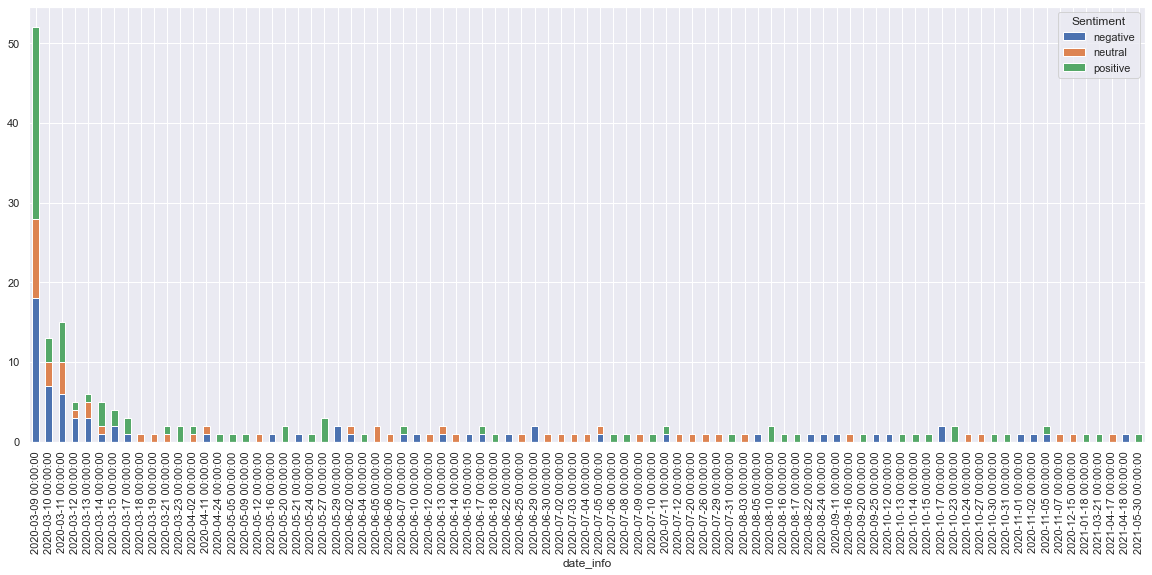

In [20]:
df1.date_info = pd.to_datetime(df1.date_info)

pd.crosstab(df1.date_info.iloc[:200],df1.Sentiment).plot.bar(stacked=True)

## Word Cloud

In [21]:
review_str = ' '.join(df1['title'].tolist()) 

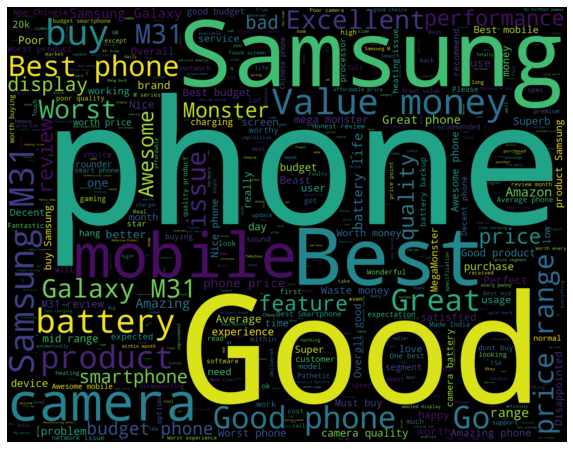

In [22]:
#Creating a WordCloud
from matplotlib.pyplot import figure
#font_path = 'C:\\Windows\\Fonts\\Metropolis\\Metropolis-Black'
wordcloud_ip = WordCloud(
                      background_color="black", max_words=500,#font_path=font_path,
               width=1800, height=1400).generate(review_str)
#figure(figsize=(2,3), dpi=300)
plt.imshow(wordcloud_ip,interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
# positive words # Choose the path for +ve words stored in system
with open(r"positive-words.txt","r") as pos:
  poswords = pos.read().split("\n")
  

# negative words  Choose path for -ve words stored in system
with open(r"negative-words.txt","r") as neg:
  negwords = neg.read().split("\n")


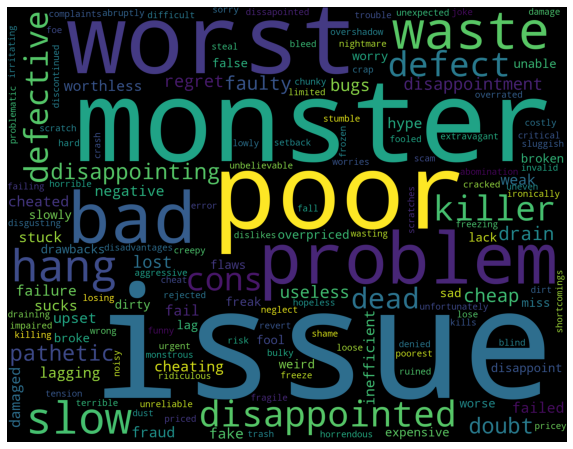

In [27]:
# negative word cloud
# Choosing the only words which are present in negwords
ip_neg_in_neg = " ".join ([w for w in review_str.split() if w in negwords])
wordcloud_neg_in_neg = WordCloud(
                     background_color='black',#font_path=font_path,
                     width=1800,
                     height=1400
                    ).generate(ip_neg_in_neg)

plt.imshow(wordcloud_neg_in_neg)
plt.axis("off")

plt.show()


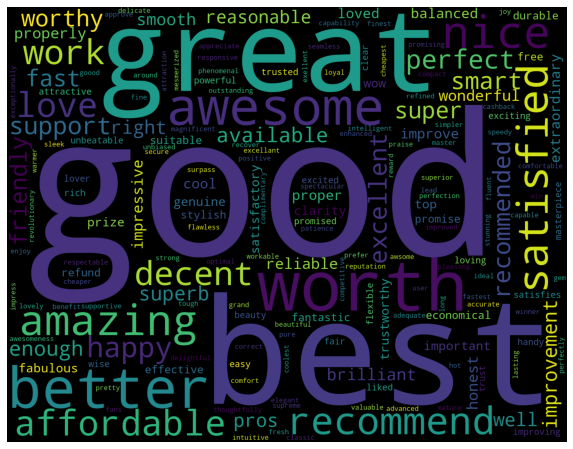

In [28]:
# Positive word cloud
# Choosing the only words which are present in positive words
ip_pos_in_pos = " ".join ([w for w in review_str.split() if w in poswords])
wordcloud_pos_in_pos = WordCloud(
                     background_color='black',#font_path=font_path, 
                        width=1800,height=1400
                     ).generate(ip_pos_in_pos)
plt.imshow(wordcloud_pos_in_pos)
plt.axis("off")
plt.show()

## Conclusion
- Perfomed Sentiment Analysis for a Samsung Phone.
- Cleaned data during preprocessing and removed stopwords.
- Used lexicon for sentiment analysis.
- Performed emotion mining and made visualizations.
- Developed word clouds for dataset and for positive and negative words.